In [1]:
!pip install -Uqq fastai

In [2]:
from fastai.vision.all import *

In [3]:
from fastai.vision.widgets import *

In [4]:
from duckduckgo_search import DDGS

In [7]:
def search_images(keywords, max_images=150):
    with DDGS() as ddgs:
        return [img['image'] for img in ddgs.images(keywords=keywords, size=None, max_results=max_images)]

In [8]:
urls = search_images('ufo', max_images=150)

In [9]:
len(urls)

99

In [12]:
path = Path('objects')
objects = 'ufo','frisbee'

In [14]:
for o in objects:
    dest = path/o
    if not dest.exists():
        dest.mkdir()
    urls = search_images(o)
    download_images(dest, urls=urls)
    resize_images(dest, max_size=400, dest=dest)

In [15]:
fns = get_image_files(path)
fns

(#283) [Path('objects/frisbee/53619903-bc28-488e-a7c3-dc37c07f825a.jpg'),Path('objects/frisbee/c812791a-a212-4792-9d8e-a1bc91ac7f72.jpg'),Path('objects/frisbee/7d835d20-c65b-47d4-8cb1-b0fe71f2a151.png'),Path('objects/frisbee/4988b146-b918-4dd6-be8d-52bc7901af5c.jpg'),Path('objects/frisbee/b8f1a05a-eb39-4b70-a851-6a474d421c1c.jpg'),Path('objects/frisbee/c10c3508-2b85-4813-a9e7-89199669b6b8.jpg'),Path('objects/frisbee/2a58bf8b-6031-4a56-87f9-a9728ec7b59e.jpg'),Path('objects/frisbee/2cdec155-eae8-4c4b-9a51-2b846f675462.jpg'),Path('objects/frisbee/bc50f61b-a6ec-480a-b1eb-f7d70c13c336.jpg'),Path('objects/frisbee/9d4d286f-6c3d-4d2c-b824-a745ffe7a02f.jpg')...]

In [16]:
failed = verify_images(fns)
failed

(#20) [Path('objects/frisbee/2a58bf8b-6031-4a56-87f9-a9728ec7b59e.jpg'),Path('objects/frisbee/585643e5-4893-484e-9c38-3b0e46c905d3.jpg'),Path('objects/frisbee/106b120b-299f-4345-8e76-aab55ce52990.svg'),Path('objects/frisbee/b2763ccd-09f1-444e-af12-1cf4d0b9b76b.jpg'),Path('objects/frisbee/d394b60b-6544-422b-8ca2-3fc29cf23cf3.jpg'),Path('objects/frisbee/4424d826-89c9-4a1e-8a51-5d1741db4828.jpg'),Path('objects/frisbee/fc5569f3-e0c1-45d6-be21-a7ea041f55d1.png'),Path('objects/frisbee/e06e508a-5529-4d8e-b14a-284abd8a0335.jpg'),Path('objects/frisbee/fc471346-f513-4daa-a38b-36d02f695bdc.jpg'),Path('objects/ufo/0adfb206-ab39-467c-86fa-f18c76019d90.jpg')...]

In [17]:
failed.map(Path.unlink);

In [18]:
objects_datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [19]:
dls = objects_datablock.dataloaders(path)

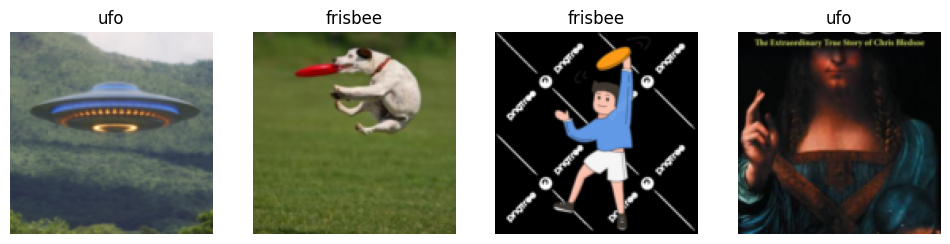

In [20]:
dls.valid.show_batch(max_n=4, nrows=1)

In [21]:
objects_datablock = objects_datablock.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2))
dls = objects_datablock.dataloaders(path)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.980772,1.807772,0.288462,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.363710,1.272670,0.269231,00:05
1,0.277397,1.061408,0.211538,00:05
2,0.212670,0.783720,0.153846,00:05
3,0.166154,0.606290,0.115385,00:05


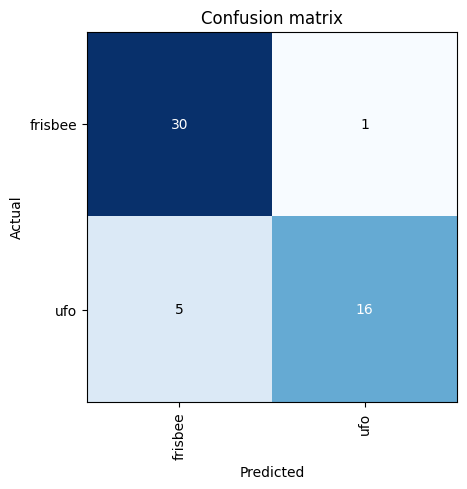

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

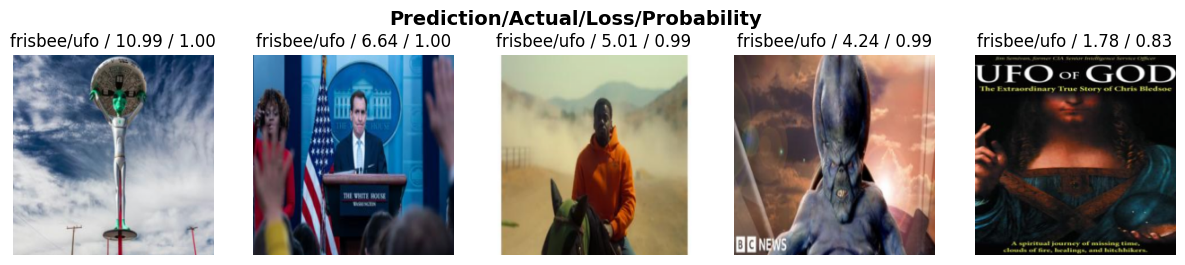

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [28]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [29]:
learn.export()

In [30]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [32]:
learn_inf = load_learner(path/'export.pkl')

In [33]:
learn_inf.predict('ufo.jpg')

('ufo', tensor(1), tensor([0.0080, 0.9920]))